# Portfolio & Risk Management I (2024)

## Homework #7: Estimating The Equity Risk Premium (GMO)

### Solutions ###

__Brief Takeaways:__
- Key outputs of GMO's forecast were: the estimate of the equity risk premium in the long term and the expected return on stocks over the intermediate term
- GMO thought that equities deserved a risk premium as they "lose money at bad times"
- GMO was interested in the expected return in the *intermediate* term because market prices can significantly differ from fundamental value, which leads to the intermediate term return possibly being different from the long-run required return
- 7 year forecast is very important to GMO's allocation decisions
- GMO decomposed the required return into the dividend yield, the multiple expansion/contraction, the change in profit margin, and the growth in sales per share.
- GMO would expect multiples and profit margins to revert to long-run (steady state) levels, and would forecast sales growth according to the business cycle (and as such it could vary from its long term growth rate)
- GMO thought that a 7-year horizon was long enough for the convergence of multiples and profit margins to their steady state levels
- GMO's view of things reverting to the mean and its belief of others' cognitive biases led them to act as somewhat of a 'contrarian', although it would take modest positions unless it had strong confidence, in which case it would be very aggressive
- In fact, GMO would hold some forms of cash simply waiting for attractive opportunities to arrive

- GMO thought that behavior of investors was often driven by concerns for short-term career risks as opposed to long-term investment performance

## Section 1: GMO

### 1.1

__*(a)*__ GMO believes that there exists a long-run 'steady state' level to which asset's returns should converge over long time horizons. This belief is founded in a belief in the economics underlying the markets, in which the markets operate in a more efficient manner. In the short run, GMO is aware of the noise that clouds markets and market participants. GMO believes that although things will eventually revert towards the 'steady state', the biases, career considerations, and shocks cause significant noise that make it difficult to predict short-run performance.

__*(b)*__ GMO uses the dividend yield, the P/E multiple expansion/contraction, the change in the profit margin, and sales growth as its predicting variables. Specifically, it believes that the profit margin and the P/E multiple have long-term steady values, and that in the long-term returns are driven by sales growth and the *required* dividend yield. This does seem to fit with the goal of long-run forecasts, which are meant to focus on the fundamental drivers of assets, not the market noise.

__*(c)*__ GMO typically expects the P/E and profit margin to revert to their long-run mean, and adjusts its expectations for dividend yield and sales growth according to their belief in the future of the business cycle. As such, when markets have elevated multiples or profit margins, GMO expects them to contract and thus takes an underweight position.

__*(d)*__ The first risk, business risk, is a result of a fund needing to secure capital long enough to see its thesis become realized. As a contrarian with a long term perspective, GMO is likely to suffer from severe underperformance while it waits for its thesis to play out. Many investors are not patient enough and may withrdraw their money, leaving GMO with no ability to function at all. Secondly, there is career risk. The risk here is that many investment professionals are driven by their concern for their position, which is largely determined by short(er) term performance. One may be reluctant to stand out if the risk of them, and them alone, being wrong leads to them being fired.

### 1.2

__*(a)*__ Firstly, we have developed significant infrastructure, theory, and general understanding over the past 50 years. As the process of searching and transacting changes, it is likely that the costs (as reflected in returns) will change as well. In addition, our development of risk-theory is likely to alter the premiums of different assets. From a more foundational perspective, one can not even be sure that the underlying economics functions similarly as it has before. New technology, whether it be the internet or blockchain have proven their ability to alter the intersection of economics and markets (or at least our perspective of such as market participants). Consider GMO's use of profit margins, for example, and how fundamentally different the business models of tech is from prior businesses.

__*(b)*__ As of 2007, the market's P/E sat at 19.5 and it's profit margin at 7.9%. These were both above GMO's steady-state levels. Also, GMO forecasted a 2.4% growth in sales as opposed to its 3.2% steady-state level, which seems to indicate that GMO anticipated an economic contraction.

__*(c)*__ GMO expects both sales growth and dividend yield to increase from 2011 levels, and expects profit margins to decrease. It has also revised its steady state P/E from 16 down to 15.

### 1.3

__*(a)*__ GMO expected US equities to have a negative return.

__*(b)*__ Foreign government bonds substantially outperformed GMO's forecast.

__*(c)*__ US Treasuries and US REITS.

### 1.4

__*(a)*__ GMWAX was most heavily positioned in US Fixed Income.

__*(b)*__ GMWAX seems to have performed fairly well in comparison. Most notably, it seemed to have less tail risk on the downside.

## Section 2: Analyzing GMO

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.regression.rolling import RollingOLS

import warnings
warnings.filterwarnings("ignore")
import os

parent_path = os.path.dirname(os.getcwd()) # Get parent path (if using .ipynb file)
# parent_path = os.path.dirname(os.path.dirname(os.path.abspath(__file__))) # Get parent path (if using .py file)
os.chdir(parent_path) # Set parent path as working directory (for reading and writing files)

In [2]:
rets = pd.read_excel('data/gmo_data.xlsx',sheet_name='total returns',index_col='date')
rfr = pd.read_excel('data/gmo_data.xlsx',sheet_name='risk-free rate',index_col='date') / 12
retsx = rets.subtract(rfr['TBill 3M'],axis=0)

In [3]:
# Create function to retrieve common statistics
def stats_mean_vol_sharpe(data,portfolio = None,portfolio_name = 'Portfolio',annualize = 12):
    
    if portfolio is None:
        returns = data
    else:
        returns = data @ portfolio
    
    output = returns.agg(['mean','std'])
    output.loc['sharpe'] = output.loc['mean'] / output.loc['std']
    
    output.loc['mean'] *= annualize
    output.loc['std'] *= np.sqrt(annualize)
    output.loc['sharpe'] *= np.sqrt(annualize)
    
    if portfolio is None:
        pass
    else:
        output.columns = [portfolio_name]
    
    return output

# Create function to calculate stats over certain periods, using any stat function
def stats_over_samples(data, samples, statfunc, **kwargs):
    '''enter (start,end) in samples as a list of tuples'''
    dfs = []
    output = pd.DataFrame()
    
    for start, end in samples:
        
        if start == 'start':
            
            if end == 'end':
                data_subsample = data
            else:
                data_subsample = data.loc[:end]
        else:
            
            if end == 'end':
                data_subsample = data.loc[start:]
            else:
                data_subsample = data.loc[start:end]
        
        stats = statfunc(data_subsample,**kwargs)
        dfs.append(stats)
        
    output = pd.concat(dfs,keys = [f'{start} - {end}' for start,end in samples])
    
    return output


# Create function to retrieve tail risk statistics
# Note this uses a simple historic definition of VaR and CVaR
def stats_tail_risk(data, portfolio = None, portfolio_name = 'Portfolio', VaR = 0.05):
    
    if portfolio is None:
        returns = data
    else:
        returns = data @ portfolio
    
    output = returns.agg(['skew',
                          'kurt'])
    output.loc['VaR'] = returns.quantile(q = 0.05)
    output.loc['CVaR'] = returns[returns <= output.loc['VaR']].mean()
    ### ^^^ THIS STEP ONLY NECESSARY IF LOOKING FOR MAX DRAWDOWN AS WELL
    if portfolio is None:
        pass
    else:
        output.columns = portfolio_name
    
    return output


# Create function to calculate max drawdown and associated dates
def max_drawdown(data, portfolio = None, portfolio_name = 'Portfolio'):
    
    if portfolio is None:
        returns = data
        output = pd.DataFrame(columns=returns.columns)
    else:
        returns = data @ portfolio
        output = pd.DataFrame(columns=[portfolio_name])
    
    cumulative = (returns + 1).cumprod()
    maximum = cumulative.expanding().max()
    drawdown = cumulative / maximum - 1
    
    for col in output.columns:
        
        output.loc['MDD',col] = drawdown[col].min()
        output.loc['Max Date',col] = cumulative[cumulative.index < drawdown[col].idxmin()][col]\
                                             .idxmax()\
                                             .date()
        output.loc['Min Date',col] = drawdown[col].idxmin().date()
        recovery_date = drawdown.loc[drawdown[col].idxmin():,col]\
                                             .apply(lambda x: 0 if x == 0 else np.nan)\
                                             .idxmax()
        
        if recovery_date is np.nan:
            output.loc['Recovery Date',col] = recovery_date
            output.loc['Recovery Period',col] = np.nan
        else:
            output.loc['Recovery Date',col] = recovery_date.date()
            output.loc['Recovery Period',col] = (output.loc['Recovery Date',col]\
                                             - output.loc['Min Date',col])\
                                             .days
        
    return output

### 2.1

In [4]:
retsx['GMWAX']

date
1996-12-31   -0.026403
1997-01-31    0.010446
1997-02-28    0.017915
1997-03-31   -0.019587
1997-04-30   -0.011092
                ...   
2024-06-28   -0.011654
2024-07-31    0.025997
2024-08-30    0.010434
2024-09-30    0.008589
2024-10-31   -0.040693
Name: GMWAX, Length: 335, dtype: float64

In [5]:
samples = [('start','2011'),('2012','end'),('start','end')]

_ = stats_over_samples(retsx,samples,stats_mean_vol_sharpe)

_.round(3)

SPY  GMWAX  GMGEX
start - 2011 mean    0.036  0.046 -0.004
             std     0.164  0.110  0.147
             sharpe  0.218  0.420 -0.026
2012 - end   mean    0.133  0.043  0.001
             std     0.141  0.095  0.236
             sharpe  0.942  0.457  0.006
start - end  mean    0.080  0.045 -0.001
             std     0.154  0.103  0.193
             sharpe  0.521  0.435 -0.008

Since this case, we have seen SPY's mean return and Sharpe ratio expand tremendously. GMWAX has had far less of a change.

### 2.2

In [6]:
# Stats using excess returns
_ = stats_over_samples(retsx,samples,stats_tail_risk)

_.round(3)

SPY  GMWAX   GMGEX
start - 2011 skew -0.514 -0.892  -0.510
             kurt  0.583  3.058   0.673
             VaR  -0.080 -0.044  -0.082
             CVaR -0.105 -0.074  -0.099
2012 - end   skew -0.498 -0.507  -6.028
             kurt  0.910  1.946  57.473
             VaR  -0.063 -0.041  -0.068
             CVaR -0.087 -0.059  -0.163
start - end  skew -0.544 -0.758  -5.131
             kurt  0.770  2.771  58.273
             VaR  -0.080 -0.041  -0.076
             CVaR -0.100 -0.069  -0.131

In [7]:
# Stats using total returns
_ = stats_over_samples(rets,samples,stats_tail_risk)

_.round(3)

SPY  GMWAX   GMGEX
start - 2011 skew -0.536 -0.884  -0.550
             kurt  0.603  3.016   0.712
             VaR  -0.079 -0.044  -0.080
             CVaR -0.104 -0.072  -0.097
2012 - end   skew -0.488 -0.471  -6.024
             kurt  0.897  2.035  57.447
             VaR  -0.062 -0.038  -0.068
             CVaR -0.086 -0.058  -0.162
start - end  skew -0.550 -0.730  -5.164
             kurt  0.783  2.731  58.687
             VaR  -0.076 -0.041  -0.076
             CVaR -0.098 -0.067  -0.129

__*(a)*__ It is interesting to note that, while being less volatile than SPY, GMWAX has a more negative skewness in all three subsamples. This seems to indicate that GMO tends to have small consistent profits and occasionally large losses. GMWAX has a notably more positive kurtosis, which is consistent with the idea that GMWAX has a higher tail risk relative to SPY. GMWAX also has smaller VaR and CVaR, however it is important to remember that it is less volatile and thus we must compare these statistics relative to that volatility. 

The plots below demonstrates this. We can see that GMO seems to have more concentrated returns but a greater tail risk. This is more easily seen in the second figure, which shows the vol-scaled histogram.

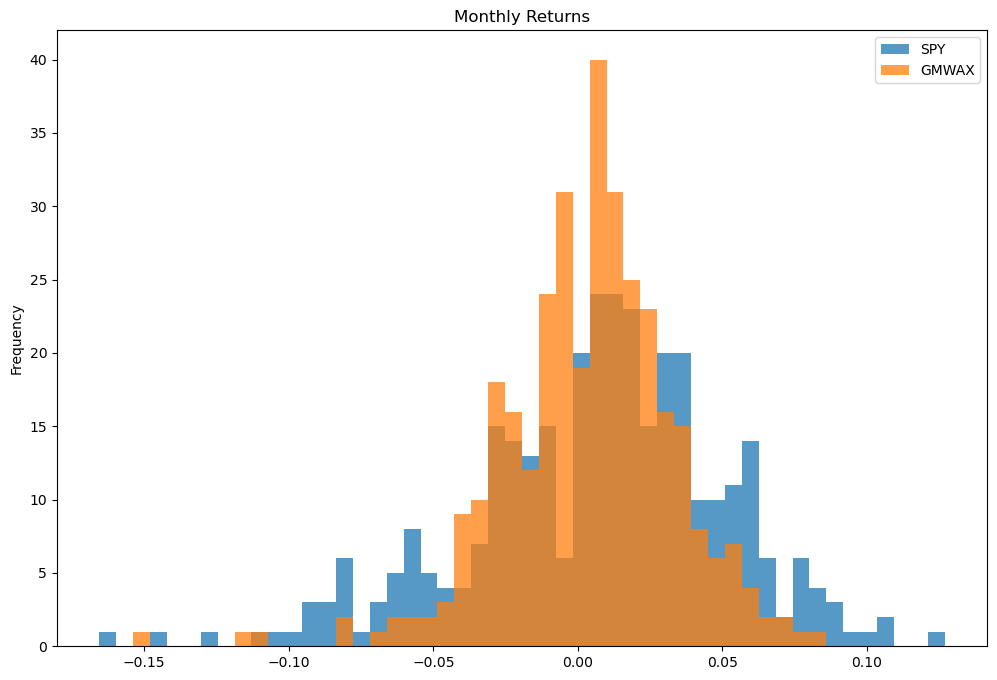

In [8]:
retsx[['SPY', 'GMWAX']].plot(kind='hist',bins=50,figsize=(12,8),alpha=0.75)
plt.title('Monthly Returns')
plt.show()

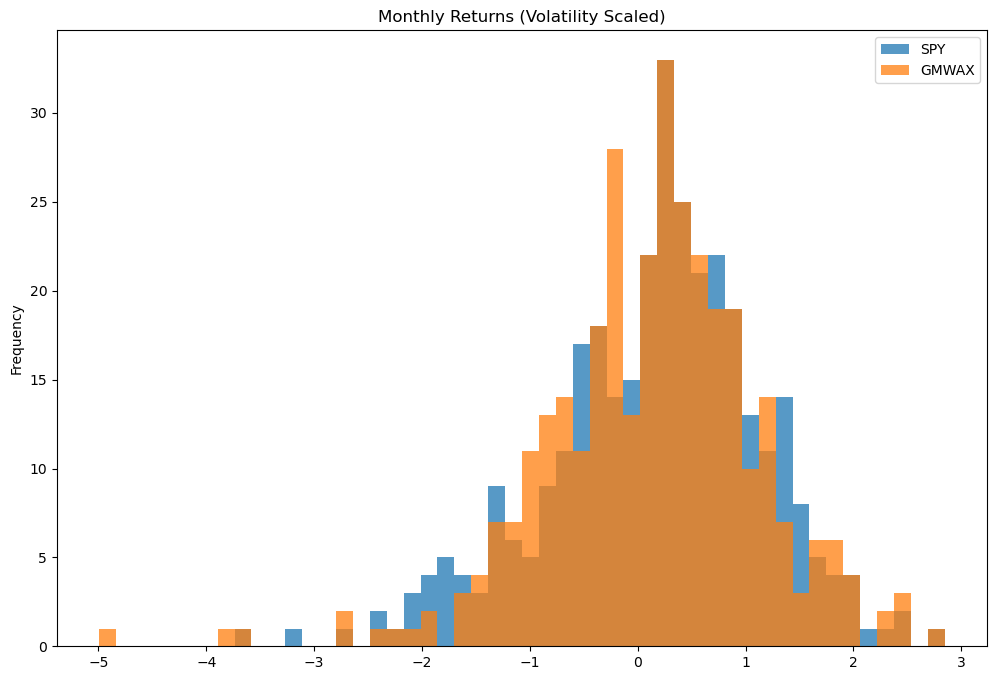

In [9]:
(retsx[['SPY', 'GMWAX']] / retsx[['SPY', 'GMWAX']].std()).plot(kind='hist',bins=50,figsize=(12,8),alpha=0.75)
plt.title('Monthly Returns (Volatility Scaled)')
plt.show()

__*(b)*__ Yes, it does. In the period through 2011, GMWAX had more extreme measures of tail risk, including a more negative skew, a higher kurtosis, more negative VaR, and greater MDD.

### 2.3

__*(a)*__

In [10]:
dfs = []

for start, end in samples:
        
    if start == 'start':
            
        if end == 'end':
            data_subsample = retsx
        else:
            data_subsample = retsx.loc[:end]
    else:
            
        if end == 'end':
            data_subsample = retsx.loc[start:]
        else:
            data_subsample = retsx.loc[start:end]
    
    y = data_subsample['GMWAX']
    x = sm.add_constant(data_subsample['SPY'])

    model = sm.OLS(y,x,missing='drop').fit()
    df = model.params
    df.loc['r-squared'] = model.rsquared
    
    dfs.append(df)

_ = pd.concat(objs = dfs,axis=1,keys = [f'{start} - {end}' for start,end in samples])
_.loc['const',:] *= 12
_.transpose().round(4)


,const,SPY,r-squared
start - 2011,0.0270,0.5421,0.6487
2012 - end,-0.0340,0.5818,0.7487
start - end,0.0006,0.5526,0.6802


__*(b)*__ GMWAX has a beta of ~0.5 throughout the periods, and this has stayed relatively consistent throught this time. Given the context of the case and the strategy, this is a low beta.

__*(c)*__ In the first subsample, yes, but we can see that it has a negative alpha since the case (shown by the second subsample). The annualized data is below.

In [11]:
_.loc[['const']] * 12

,start - 2011,2012 - end,start - end
const,0.324005,-0.407519,0.006702


All in all, we find that GMWAX has had mediocre *relative* performance, particularly since 2012. With a beta close to 0.5 with SPY but a lower Sharpe and a negative skew, it seems that GMWAX is not quite attractive. This is demonstrated further by the negative alpha since 2012. It is important to note that this does not solidify the case against GMWAX. For one, it could be capturing a different risk measure, or have exposure to a different risk measure than market risk. If the premium of such a measure turned negative since 2012, one may actually find GMWAX's alpha to be positive.

Lastly, and reflective of GMO's strategy, GMWAX tends to have its returns come from a few large return months (positve, or negative), which is consistent with the large excess kurtosis statistic found before. This is also consistent with the beliefs behind GMO's strategy, which often leads to "contrarian" positions aimed at price bubbles that can move precipitously.

## Section 3: Forecast Regressions

__Note:__ For this section, there is some ambiguity as to whether we should use excess or total returns. Here, I will use excess returns because this is most pertinent to forecasting. If I feel confident that I can predict the risk free rate, then we should strip this out and focus on modelling the less-predictable excess returns on their own.

In [12]:
signals = pd.read_excel('data/gmo_data.xlsx',sheet_name='signals',index_col='date')

### 3.1

Dividend-Price Ratio (Dividend Yield):

In [13]:
y = retsx['SPY']
x = sm.add_constant(signals['SPX DVD YLD']).shift()

model_dp = sm.OLS(y,x,missing='drop').fit()

print(model_dp.summary())

                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     4.727
Date:                Mon, 09 Dec 2024   Prob (F-statistic):             0.0304
Time:                        11:07:43   Log-Likelihood:                 567.58
No. Observations:                 334   AIC:                            -1131.
Df Residuals:                     332   BIC:                            -1124.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0171      0.011     -1.519      

Earnings-Price Ratio (P/E):

In [14]:
y = retsx['SPY']
x = sm.add_constant(signals['SPX P/E']).shift()

model_ep = sm.OLS(y,x,missing='drop').fit()

print(model_ep.summary())

                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     2.011
Date:                Mon, 09 Dec 2024   Prob (F-statistic):              0.157
Time:                        11:07:43   Log-Likelihood:                 566.23
No. Observations:                 334   AIC:                            -1128.
Df Residuals:                     332   BIC:                            -1121.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0227      0.011      1.981      0.0

DP, EP, and 10-year yield:

In [15]:
y = retsx['SPY']
x = sm.add_constant(signals).shift()

model_all = sm.OLS(y,x,missing='drop').fit()

print(model_all.summary())

                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.841
Date:                Mon, 09 Dec 2024   Prob (F-statistic):              0.140
Time:                        11:07:43   Log-Likelihood:                 567.99
No. Observations:                 334   AIC:                            -1128.
Df Residuals:                     330   BIC:                            -1113.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0155      0.036     -0.429      

### 3.2

In [16]:
# Build the return predictions, and align them with the right period
all_prediction = model_all.predict(sm.add_constant(signals)).shift()
dp_prediction = model_dp.predict(sm.add_constant(signals['SPX DVD YLD'])).shift()
ep_prediction = model_ep.predict(sm.add_constant(signals['SPX P/E'])).shift()

# Build the strategy weighting in SPY
all_weight = 100 * all_prediction
dp_weight = 100 * dp_prediction
ep_weight = 100 * ep_prediction

# Compute the strategy returns
all_strat = all_weight * retsx['SPY']
dp_strat = dp_weight * retsx['SPY']
ep_strat = ep_weight * retsx['SPY']

In [17]:
_ = pd.concat([all_strat,dp_strat,ep_strat],axis=1,keys = ['All','SPX DVD YLD','SPX P/E'])
stats_mean_vol_sharpe(_)

,All,SPX DVD YLD,SPX P/E
mean,0.094858,0.089093,0.070008
std,0.165277,0.165365,0.123267
sharpe,0.573933,0.538765,0.567939


In [18]:
stats_tail_risk(_)

,All,SPX DVD YLD,SPX P/E
skew,0.112820,-0.103132,-0.449678
kurt,12.485581,15.821042,4.295560
VaR,-0.047548,-0.049193,-0.049371
CVaR,-0.106298,-0.107035,-0.084034


In [19]:
# Redefine the above function
def LFPM_TS(assets, factors, annualize = 12, name = 'asset', treynor = False, mkt_name = 'MKT'):
    '''Alpha, IR, Treynor are annualized (only the stats output)'''

    if isinstance(assets,pd.Series):
        assets = pd.DataFrame(assets)
        assets.columns = [name]
    
    if isinstance(factors,pd.Series):
        factors = pd.DataFrame(factors)
    
    model_output = pd.DataFrame()
    stats_output = pd.DataFrame()
    residuals_output = pd.DataFrame()
    
    x = sm.add_constant(factors)
    
    for asset in assets.columns:
        
        # Create the model
        y = assets[asset]
        model = sm.OLS(y,x,missing='drop').fit()
        
        # Create the parameters dataframe
        model_output[asset] = model.params
        
        # Create the statistics dataframe
        mu = y.mean() * annualize
        alpha = model.params[0] * annualize
        sig_ep = model.resid.std() * np.sqrt(annualize)
        IR = alpha / sig_ep
        r_squared = model.rsquared
        
        stats_output[asset] = pd.Series(data = [alpha,IR,r_squared],index = ['Alpha','IR','$R^{2}$'])
        
        if treynor:
            mkt = model.params[mkt_name]
            TR = mu / mkt
            
            stats_output.loc['Treynor',asset] = TR
        
        # Create the residuals dataframe
        residuals_output[asset] = model.resid
        
    return model_output, stats_output, residuals_output

In [20]:
LFPM_TS(_,retsx['SPY'])[1]

,All,SPX DVD YLD,SPX P/E
Alpha,0.031548,0.024719,0.012190
IR,0.276848,0.220838,0.214076
$R^{2}$,0.524612,0.541815,0.786605


As we expect, the strategies are correlated to SPY, but less than one might expect. This seems to indicate a solid strategy.

### 3.3

__*(a)*__

In [21]:
strats_df = pd.concat([_,retsx],axis = 1)

strats_df.quantile(0.05)

All           -0.047548
SPX DVD YLD   -0.049193
SPX P/E       -0.049371
SPY           -0.079673
GMWAX         -0.041368
GMGEX         -0.076213
Name: 0.05, dtype: float64

__*(b)*__

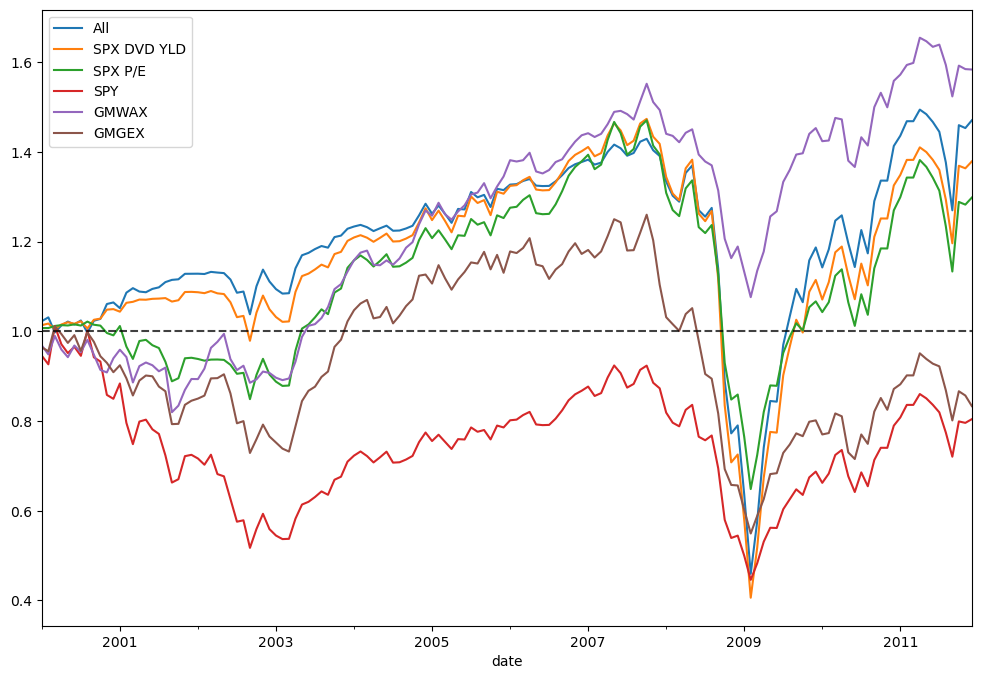

In [22]:
(strats_df.loc['2000':'2011'] + 1).cumprod().plot(figsize=(12,8))
plt.axhline(1,c ='black',alpha=0.75,ls = '--')
plt.show()

We see that all but SPY (and GMGEX) outperform the risk-free rate during this time.

__*(c)*__

In [23]:
# All signals
(dp_prediction.dropna() < 0).sum() / len(dp_prediction.dropna())

0.10179640718562874

In [24]:
# All signals
(ep_prediction.dropna() < 0).sum() / len(ep_prediction.dropna())

0.05688622754491018

In [25]:
# All signals
(all_prediction.dropna() < 0).sum() / len(all_prediction.dropna())

0.11377245508982035

For all three models we find that we rarely have a negative risk premium for SPY.

__*(d)*__ Statistics such as CVAR, MDD, and kurtosis all point to the dynamic strategies taking on a new form of risk relative to SPY. Even though the dynamic strategies have similar volatilies as SPY and positive alpha, they clearly have a substantially different return distribution than that of SPY.

## Section 4: Out-of-Sample Forecasting

In [26]:
def oos_forecast(signals, asset, t = 60, rolling = False, roll_exp = False, intercept = True):
    
    '''
    Computes an out-of-sample forecast based on expanding regression periods
    
    signals: DataFrame containing the signals (regressors) to be used in each regression
    asset: DataFrame containing the values (returns) of the asset being predicted
    t: The minimum number of periods
    rolling: False if expanding, else enter an integer window
    roll_exp: If using rolling, indicate whether to use expanding up to the minimum periods 
    intercept: Boolean indicating the inclusion of an intercept in the regressions
    '''
    
    n = len(signals)
    
    if intercept:
        signals = sm.add_constant(signals)
    
    if t > n:
        
        raise ValueError('Min. periods (t) greater than number of data points')
    
    output = pd.DataFrame(index = signals.index, columns = ['Actual','Predicted','Null'])
    
    # If expanding
    if not rolling:
        
        for i in range(t,n):

            y = asset.iloc[:i]
            x = signals.iloc[:i].shift()

            if intercept:
                null_pred = y.mean()

            else:
                null_pred = 0

            model = sm.OLS(y,x,missing='drop').fit()

            pred_x = signals.iloc[[i - 1]]
            pred = model.predict(pred_x)[0]
            output.iloc[i]['Actual'] = asset.iloc[i]
            output.iloc[i]['Predicted'] = pred
            output.iloc[i]['Null'] = null_pred
    
    # If rolling
    else:
        
        if rolling > n:
            
            raise ValueError('Rolling window greater than number of data points')
        
        y = asset
        x = signals.shift()
        
        if intercept:
            
            if roll_exp:
                null_pred = y.rolling(window = rolling, min_periods = 0).mean().shift()
            else:
                null_pred = y.rolling(window = rolling).mean().shift()

        else:
            null_pred = 0
        
        # When expanding == True, there is a minimum number of observations
        # Keep ^ in mind
        model = RollingOLS(y,x,window = rolling, expanding = roll_exp).fit()

        output['Actual'] = asset
        output['Predicted'] = (model.params * signals).dropna().sum(axis=1).shift()
        output['Null'] = null_pred
        
        
    return output


def oos_r_squared(data):
    
    '''
    Computes the out-of-sample r squared
    data: DataFrame containing actual, model-predicted, and null-predicted values
    '''
    
    model_error = data['Actual'] - data['Predicted']
    null_error = data['Actual'] - data['Null']
    
    r2_oos = 1 - (model_error ** 2).sum() / (null_error ** 2).sum()
    
    return r2_oos


# Create a trading returns func that takes in a trading implementation func

In [27]:
oos_ep_dp = oos_forecast(signals[['SPX DVD YLD', 'SPX P/E']], retsx['SPY'])

oos_r_squared(oos_ep_dp)

-0.057691580402814635

No, this strategy id not produce a positive OOS r-squared. It performed worse than the simple expanding mean.

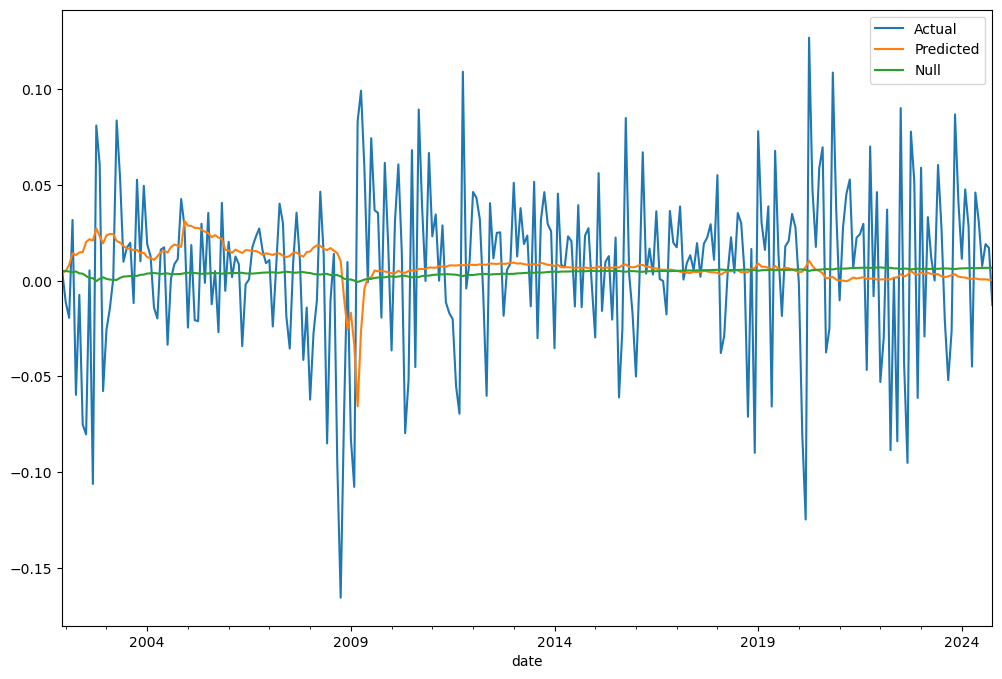

In [28]:
oos_ep_dp.dropna().plot(figsize=(12,8))
plt.show()

### 4.2

In [29]:
ep_dp_oos_weight = 100 * oos_ep_dp['Predicted']

ep_dp_oos_strat = (ep_dp_oos_weight * oos_ep_dp['Actual']).astype(float)

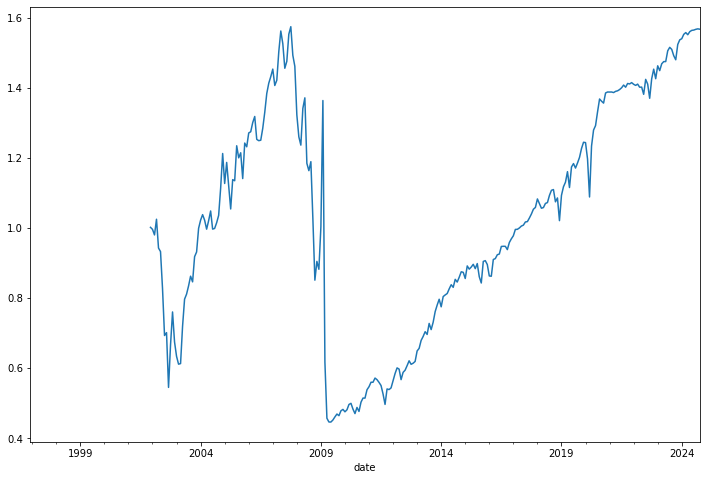

In [ ]:
(1 + ep_dp_oos_strat).cumprod().plot(figsize=(12,8))
plt.show()

The two plots above both show that the predictions around 2009 drastically reduce the performance of the OOS model, both from an $R^2$ perspective as well as a cumulative returns perspective.

In [ ]:
stats_mean_vol_sharpe(ep_dp_oos_strat)

mean      0.046676
std       0.214650
sharpe    0.217453
dtype: float64

In [ ]:
stats_tail_risk(ep_dp_oos_strat.rename('EP DP OOS').to_frame())

,EP DP OOS
skew,-2.256126
kurt,28.14692
VaR,-0.06051
CVaR,-0.161214
MDD,-0.716296
Max Date,2007-10-31
Min Date,2009-06-30
Recovery Date,NaN
Recovery Period,NaN


In [ ]:
LFPM_TS(ep_dp_oos_strat,retsx['SPY'])[1]

,asset
Alpha,0.001153
IR,0.005792
$R^{2}$,0.139622


### 4.3

__*(a)*__

In [ ]:
ep_dp_oos_strat.quantile(0.05)

-0.06051014396735028

The 5% VaR of the strategy is notably worse than the in-sample version, but still more positive than that of SPY.

__*(b)*__ Yes, from the cumulative returns chart above it is clear that the out of sample strategy struggled significantly in the market crash.

__*(c)*__

In [ ]:
# OOS DP and EP signals
(oos_ep_dp['Predicted'].dropna() < 0).sum() / len(oos_ep_dp['Predicted'].dropna())

0.02909090909090909

The out of sample model has a negative risk premium even less frequently, occurring only 3% of the time.

__*(d)*__ Yes, for the reasons outlined above.

## Section 5: CART and NN

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression

### In Sample ###

In [ ]:
def ml_model_predictions(model_cols, returns, signals, return_col, plots = False):
    
    forecasts_ML = returns.loc[:,[return_col]].expanding().mean().shift(1).dropna() 
    forecasts_ML.columns = ['Expanding Mean']

    score_ML = pd.DataFrame(columns=['Expanding Mean'],index=['score'],data=0)

    methods = ['OLS', 'Tree', 'NN']
    est = dict()

    y = returns.loc[:,[return_col]].iloc[1:].squeeze('columns').ravel()
    X = signals.loc[:,model_cols].shift(1).dropna()

    for method in methods:

        if method == 'OLS':
            est[method] = LinearRegression()
        elif method == 'Tree':
            est[method] = RandomForestRegressor(max_depth=3,random_state=1)
        elif method == 'NN':
            est[method] = MLPRegressor(hidden_layer_sizes=500,random_state=1)

        est[method].fit(X,y)
        forecasts_ML[method] = est[method].predict(X)
        score_ML[method] = est[method].score(X,y)    

    forecasts_ML.dropna(inplace=True)
    wts_ML = 100 * forecasts_ML

    spy_ML, _ = returns.loc[:,[return_col]].iloc[1:].align(forecasts_ML, join='right', axis=0)

    fund_returns_ML = wts_ML * spy_ML.values
    fund_returns_ML.insert(0,'Passive', spy_ML)
    
    if plots:
        fn = X.columns
        fig, axes = plt.subplots(nrows = 1,ncols=1, dpi=500);
        tree.plot_tree(est['Tree'].estimators_[0],feature_names = fn, filled=True)
        if len(model_cols) > 1:
            title_name = '-'.join(str(v) for v in model_cols)
        else:
            title_name = model_cols[0]
        plt.title('Signal - '+title_name, fontsize = 20)

    return fund_returns_ML

In [ ]:
ML_forecast_DP = ml_model_predictions(['SPX DVD YLD'], retsx, signals, 'SPY')
ML_forecast_EP = ml_model_predictions(['SPX P/E'], retsx, signals, 'SPY')
ML_forecast_All = ml_model_predictions(['SPX DVD YLD','SPX P/E','TNote 10YR'], retsx, signals, 'SPY')

__Dividend Yield:__

In [ ]:
stats_mean_vol_sharpe(ML_forecast_DP)

,Passive,Expanding Mean,OLS,Tree,NN
mean,0.081732,0.034274,0.089093,0.232886,0.291874
std,0.154545,0.124289,0.165365,0.229680,0.478885
sharpe,0.528857,0.275759,0.538765,1.013958,0.609487


In [ ]:
stats_tail_risk(ML_forecast_DP)

,Passive,Expanding Mean,OLS,Tree,NN
skew,-0.550278,-1.148924,-0.103132,3.92741,-0.447338
kurt,0.775821,10.498586,15.821042,22.478481,5.437229
VaR,-0.079683,-0.050512,-0.049193,-0.046519,-0.192516
CVaR,-0.09954,-0.089454,-0.107035,-0.069937,-0.320223
MDD,-0.559175,-0.391577,-0.724389,-0.254825,-0.985431
Max Date,2000-03-31,1999-12-31,2007-10-31,2007-10-31,2007-10-31
Min Date,2009-02-27,2009-04-30,2009-02-27,2008-09-30,2009-02-27
Recovery Date,2013-03-29,2019-04-30,2012-02-29,2008-10-31,2014-11-28
Recovery Period,1491,3652,1097,31,2100


__P/E:__

In [ ]:
stats_mean_vol_sharpe(ML_forecast_EP)

,Passive,Expanding Mean,OLS,Tree,NN
mean,0.081732,0.034274,0.070008,0.198416,-0.070599
std,0.154545,0.124289,0.123267,0.193195,0.148110
sharpe,0.528857,0.275759,0.567939,1.027028,-0.476663


In [ ]:
stats_tail_risk(ML_forecast_EP)

,Passive,Expanding Mean,OLS,Tree,NN
skew,-0.550278,-1.148924,-0.449678,4.499686,0.564013
kurt,0.775821,10.498586,4.29556,35.05859,0.863287
VaR,-0.079683,-0.050512,-0.049371,-0.038227,-0.069103
CVaR,-0.09954,-0.089454,-0.084034,-0.061659,-0.083246
MDD,-0.559175,-0.391577,-0.559044,-0.410928,-0.897502
Max Date,2000-03-31,1999-12-31,2007-10-31,2007-10-31,1997-03-31
Min Date,2009-02-27,2009-04-30,2009-02-27,2009-01-30,2024-09-30
Recovery Date,2013-03-29,2019-04-30,2012-03-30,2009-04-30,NaN
Recovery Period,1491,3652,1127,90,NaN


__All:__

In [ ]:
stats_mean_vol_sharpe(ML_forecast_All)

,Passive,Expanding Mean,OLS,Tree,NN
mean,0.081732,0.034274,0.094858,0.268768,0.188177
std,0.154545,0.124289,0.165277,0.239805,0.373257
sharpe,0.528857,0.275759,0.573933,1.120780,0.504149


In [ ]:
stats_tail_risk(ML_forecast_All)

,Passive,Expanding Mean,OLS,Tree,NN
skew,-0.550278,-1.148924,0.11282,5.194662,0.066443
kurt,0.775821,10.498586,12.485581,43.535999,3.140086
VaR,-0.079683,-0.050512,-0.047548,-0.042227,-0.17383
CVaR,-0.09954,-0.089454,-0.106298,-0.053381,-0.24974
MDD,-0.559175,-0.391577,-0.678516,-0.161011,-0.728197
Max Date,2000-03-31,1999-12-31,2007-10-31,2007-10-31,2020-11-30
Min Date,2009-02-27,2009-04-30,2009-02-27,2008-09-30,2022-09-30
Recovery Date,2013-03-29,2019-04-30,2011-01-31,2008-10-31,NaN
Recovery Period,1491,3652,703,31,NaN


### Out of Sample ###

In [ ]:
def oos_ml_model_predictions(model_cols, returns, signals, return_col, window = 60):


    methods = ['OLS', 'Tree', 'NN']
    est = dict()

    forecasts_MLOOS = pd.DataFrame(columns=methods,index=returns.iloc[1:].index,dtype='float64')


    y = returns.loc[:,[return_col]].iloc[1:].squeeze('columns').ravel()
    Xlag = signals.loc[:,model_cols].shift(1).dropna()
    X = signals.loc[:,model_cols]

    for method in methods:

        for t in returns.iloc[1:].index[window-1:]:
            yt = returns.loc[:,[return_col]].iloc[1:].loc[:t].values.ravel()
            Xlag_t = Xlag.loc[:t,:].values
            x_t = X.loc[t,:].values.reshape(1,-1)

            if method == 'OLS':
                est = LinearRegression()
            elif method == 'Tree':
                est = RandomForestRegressor(max_depth=3,random_state=1)
            elif method == 'NN':
                est = MLPRegressor(hidden_layer_sizes=500,random_state=1)

            est.fit(Xlag_t,yt);
            predval = est.predict(x_t)[0]
            forecasts_MLOOS.loc[t,method] = predval

    forecasts_MLOOS.insert(0,'Mean', returns.loc[:,[return_col]].expanding().mean().shift(1).dropna())

    # prefer to date forecast by date of forecasted value, not date it was calculated
    forecasts_MLOOS = forecasts_MLOOS.shift(1).dropna()


    wts_MLOOS = 100 * forecasts_MLOOS

    spy_MLOOS, _ = returns.loc[:,[return_col]].iloc[1:].align(forecasts_MLOOS, join='right', axis=0)

    fund_returns_MLOOS = wts_MLOOS * spy_MLOOS.values
    fund_returns_MLOOS.insert(0,'Passive', spy_MLOOS)

    sigma_t = fund_returns_MLOOS.rolling(24).std()
    relative_vols = pd.DataFrame(sigma_t[['Passive']].to_numpy() / sigma_t.drop(columns=['Passive']).to_numpy(),columns=sigma_t.drop(columns=['Passive']).columns, index=sigma_t.index)
    wts_t = relative_vols * wts_MLOOS
    fund_returns_MLOOS = wts_t * spy_MLOOS.values
    fund_returns_MLOOS.insert(0,'Passive', spy_MLOOS)

    fund_returns_MLOOS.dropna(inplace=True)

    null = returns.loc[:,[return_col]].expanding(window+1).mean().shift(1).dropna() 
    actual = returns.loc[:,[return_col]].iloc[window+1:]

    forecast_err = pd.DataFrame()
    null_err = pd.DataFrame()
    for col in forecasts_MLOOS.columns:
        forecast_err[col] = forecasts_MLOOS[col] - actual[return_col]
        null_err[col] = null[return_col] - actual[return_col]
        
    oos_r2 = 1-(((forecast_err**2).sum())/(null_err**2).sum()).to_frame('OOS R-Squared')


    return (fund_returns_MLOOS,oos_r2)

In [ ]:
ML_oos_forecast_DP = oos_ml_model_predictions(['SPX DVD YLD'], retsx, signals, 'SPY')
ML_oos_forecast_EP = oos_ml_model_predictions(['SPX P/E'], retsx, signals, 'SPY')
ML_oos_forecast_All = oos_ml_model_predictions(['SPX DVD YLD','SPX P/E','TNote 10YR'], retsx, signals, 'SPY')

__Dividend Yield:__

In [ ]:
ML_oos_forecast_DP[1]

,OOS R-Squared
Mean,-0.000959
OLS,-0.039607
Tree,-0.125754
NN,-0.894291


In [ ]:
stats_mean_vol_sharpe(ML_oos_forecast_DP[0])

,Passive,Mean,OLS,Tree,NN
mean,0.094606,0.095056,0.075882,0.061510,0.012208
std,0.147048,0.148225,0.143328,0.148841,0.137714
sharpe,0.643370,0.641292,0.529427,0.413256,0.088649


In [ ]:
stats_tail_risk(ML_oos_forecast_DP[0])

,Passive,Mean,OLS,Tree,NN
skew,-0.579703,-0.443946,-0.282729,0.517494,-0.41608
kurt,1.320162,0.816442,4.104667,6.495519,3.099928
VaR,-0.070341,-0.073612,-0.063767,-0.07156,-0.064721
CVaR,-0.096034,-0.092567,-0.099314,-0.097053,-0.099867
MDD,-0.517254,-0.416292,-0.491233,-0.469207,-0.674647
Max Date,2007-05-31,2007-05-31,2007-10-31,2009-02-27,2007-10-31
Min Date,2009-02-27,2009-06-30,2009-04-30,2011-09-30,2013-09-30
Recovery Date,2012-09-28,2013-03-29,2014-02-28,2014-11-28,NaN
Recovery Period,1309,1368,1765,1155,NaN


__P/E:__

In [ ]:
ML_oos_forecast_EP[1]

,OOS R-Squared
Mean,-0.000959
OLS,-0.011352
Tree,-0.132596
NN,-1.819016


In [ ]:
stats_mean_vol_sharpe(ML_oos_forecast_EP[0])

,Passive,Mean,OLS,Tree,NN
mean,0.094606,0.095056,0.065810,0.027060,-0.040649
std,0.147048,0.148225,0.147019,0.140589,0.139299
sharpe,0.643370,0.641292,0.447631,0.192476,-0.291811


In [ ]:
stats_tail_risk(ML_oos_forecast_EP[0])

,Passive,Mean,OLS,Tree,NN
skew,-0.579703,-0.443946,-0.229344,-1.69007,0.13608
kurt,1.320162,0.816442,3.058677,6.587509,3.130827
VaR,-0.070341,-0.073612,-0.066292,-0.067183,-0.067188
CVaR,-0.096034,-0.092567,-0.101534,-0.117869,-0.094331
MDD,-0.517254,-0.416292,-0.411339,-0.539329,-0.805187
Max Date,2007-05-31,2007-05-31,2007-10-31,2007-05-31,2009-02-27
Min Date,2009-02-27,2009-06-30,2009-03-31,2011-09-30,2021-08-31
Recovery Date,2012-09-28,2013-03-29,2012-03-30,2018-02-28,NaN
Recovery Period,1309,1368,1095,2343,NaN


__All:__

In [ ]:
ML_oos_forecast_All[1]

,OOS R-Squared
Mean,-0.000959
OLS,-0.072594
Tree,-0.171640
NN,-10.007845


In [ ]:
stats_mean_vol_sharpe(ML_oos_forecast_All[0])

,Passive,Mean,OLS,Tree,NN
mean,0.094606,0.095056,0.070469,0.005286,-0.038273
std,0.147048,0.148225,0.147943,0.145831,0.155140
sharpe,0.643370,0.641292,0.476328,0.036245,-0.246700


In [ ]:
stats_tail_risk(ML_oos_forecast_All[0])

,Passive,Mean,OLS,Tree,NN
skew,-0.579703,-0.443946,-0.356195,-0.845323,-0.445736
kurt,1.320162,0.816442,4.249333,9.309396,3.414373
VaR,-0.070341,-0.073612,-0.068146,-0.072431,-0.081
CVaR,-0.096034,-0.092567,-0.101765,-0.113906,-0.117662
MDD,-0.517254,-0.416292,-0.458918,-0.523849,-0.689944
Max Date,2007-05-31,2007-05-31,2007-10-31,2019-12-31,2004-04-30
Min Date,2009-02-27,2009-06-30,2011-09-30,2022-09-30,2022-09-30
Recovery Date,2012-09-28,2013-03-29,2013-12-31,NaN,NaN
Recovery Period,1309,1368,823,NaN,NaN
